In [ ]:
# ====================================================
# 1. Import Necessary Libraries
# ====================================================
import os
import random
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from glob import glob
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from PIL import Image

In [ ]:
# ====================================================
# 2. Define Configurations
# ====================================================
BATCH_SIZE = 16
IMG_SIZE = 224
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ====================================================
# 3. تحميل البيانات من Kaggle واستخراجها
# ====================================================
from google.colab import files
import zipfile

# رفع ملف kaggle.json يدويًا
files.upload()  # تأكد من رفع kaggle.json

# نقل ملف Kaggle API إلى المكان الصحيح
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# تحميل البيانات
!kaggle competitions download -c open-data-day-2025-dates-types-classification

# استخراج البيانات
with zipfile.ZipFile("open-data-day-2025-dates-types-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

print("✅ Files extracted successfully!")

Saving kaggle.json to kaggle.json
open-data-day-2025-dates-types-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
✅ Files extracted successfully!


In [ ]:
from pathlib import Path

data_path = Path("/content/data")  # المسار الرئيسي للبيانات
train_path = data_path / "/content/data/train"
test_path = data_path / "/content/data/test"

# قراءة ملف التصنيفات
csv_path = data_path / "/content/data/train_labels.csv"
train_df = pd.read_csv(csv_path)
train_df["path"] = train_path / train_df["filename"]
train_df.drop("filename", axis=1, inplace=True)

test_paths = glob("/content/data/test/*")
test_df = pd.DataFrame({"path": test_paths})

# التحقق من البيانات
print("Train Shape:", train_df.shape)
print("Test  Shape:", test_df.shape)
print(train_df.head())

Train Shape: (432, 2)
Test  Shape: (126, 1)
  label                              path
0  Ajwa  /content/data/train/feda0fb2.jpg
1  Ajwa  /content/data/train/f10703e9.png
2  Ajwa  /content/data/train/04cdb8ab.jpg
3  Ajwa  /content/data/train/56fa4cc4.jpg
4  Ajwa  /content/data/train/e17feef7.jpg


In [ ]:
# ====================================================
# 3. Download Data from Kaggle and Extract in Kaggle
# ====================================================
train_df = pd.read_csv("/kaggle/input/open-data-day-2025-dates-types-classification/train_labels.csv")
train_df["path"] = "/kaggle/input/open-data-day-2025-dates-types-classification/train/" + train_df["filename"]
train_df.drop("filename", axis=1, inplace=True)
train_df = train_df[["path","label"]]

test_paths = glob("/kaggle/input/open-data-day-2025-dates-types-classification/test/*")
test_df = pd.DataFrame({"path": test_paths})

print("Train Shape:", train_df.shape)
print("Test  Shape:", test_df.shape)
print(train_df.head())

In [ ]:
label_mapping = {
    "Ajwa": 0,
    "Medjool": 1,
    "Meneifi": 2,
    "Nabtat Ali": 3,
    "Shaishe": 4,
    "Sokari": 5,
    "Sugaey": 6
}

# Add label indices to DataFrame
train_df["label_idx"] = train_df["label"].map(label_mapping)

In [ ]:
# ====================================================
# 4. Define Data Augmentation and Preprocessing
# ====================================================
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# ====================================================
# 5. Create Custom Dataset Class
# ====================================================
'''class DatesDataset(Dataset):
    def __init__(self, dataframe, transform=None, train=True):
        self.dataframe = dataframe
        self.transform = transform
        self.train = train

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.train:
            label = self.dataframe.iloc[idx]['label_idx']  # Use pre-mapped label index
            return image, label
        else:
            return image'''

class DatesDataset(Dataset):
    def __init__(self, dataframe, transform=None, train=True):
        self.dataframe = dataframe
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.dataframe)  # Add this line

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.train:
            label = self.dataframe.iloc[idx]['label_idx']  # Use pre-mapped label index
            return image, label
        else:
            return image

In [ ]:
# ====================================================
# 6. Handle Class Imbalance with Weighted Sampling
# ====================================================
labels = train_df['label'].values
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# Create label-to-index mapping
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}

# Create sample weights based on numerical indices
sample_weights = train_df['label'].map(lambda x: class_weights[label_to_index[x]].item()).values
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
# ====================================================
# 7. Create DataLoaders
# ====================================================
train_dataset = DatesDataset(train_df, transform=train_transforms, train=True)
test_dataset = DatesDataset(test_df, transform=test_transforms, train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
# ====================================================
# 8. Define Model (ConvNeXt-Tiny)
# ====================================================
model = models.convnext_tiny(pretrained=True)
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(label_mapping))  # Use len(label_mapping) instead of np.unique
model = model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# ====================================================
# 9. Define Loss Function and Optimizer
# ====================================================
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# ====================================================
# 10. Training Loop
# ====================================================
def train_model(model, train_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS)

Epoch [1/20], Loss: 1.0828
Epoch [2/20], Loss: 0.2244
Epoch [3/20], Loss: 0.0795
Epoch [4/20], Loss: 0.0839
Epoch [5/20], Loss: 0.0355
Epoch [6/20], Loss: 0.0227
Epoch [7/20], Loss: 0.0204
Epoch [8/20], Loss: 0.0141
Epoch [9/20], Loss: 0.0112
Epoch [10/20], Loss: 0.0042
Epoch [11/20], Loss: 0.0121
Epoch [12/20], Loss: 0.0160
Epoch [13/20], Loss: 0.0122
Epoch [14/20], Loss: 0.0043
Epoch [15/20], Loss: 0.0110
Epoch [16/20], Loss: 0.0488
Epoch [17/20], Loss: 0.0055
Epoch [18/20], Loss: 0.0055
Epoch [19/20], Loss: 0.0123
Epoch [20/20], Loss: 0.0103


In [ ]:
# ====================================================
# 11. Make Predictions on Test Set and Save to CSV
# ====================================================
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

# Make sure the model is in evaluation mode
model.eval()

# Collecting predictions and corresponding labels for test images
predictions = []
true_labels = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame with predictions for submission
label_mapping_inv = {v: k for k, v in label_mapping.items()}  # Reverse mapping

submission_df = pd.DataFrame({
    "filename": [os.path.basename(path) for path in test_paths],
    "label": [label_mapping_inv[pred] for pred in predictions]
})
submission_df.to_csv("submission.csv", index=False)

# Save the submission file
submission_df.to_csv("submission.csv", index=False)
print("Submission saved to submission.csv.")


Submission saved to submission.csv.


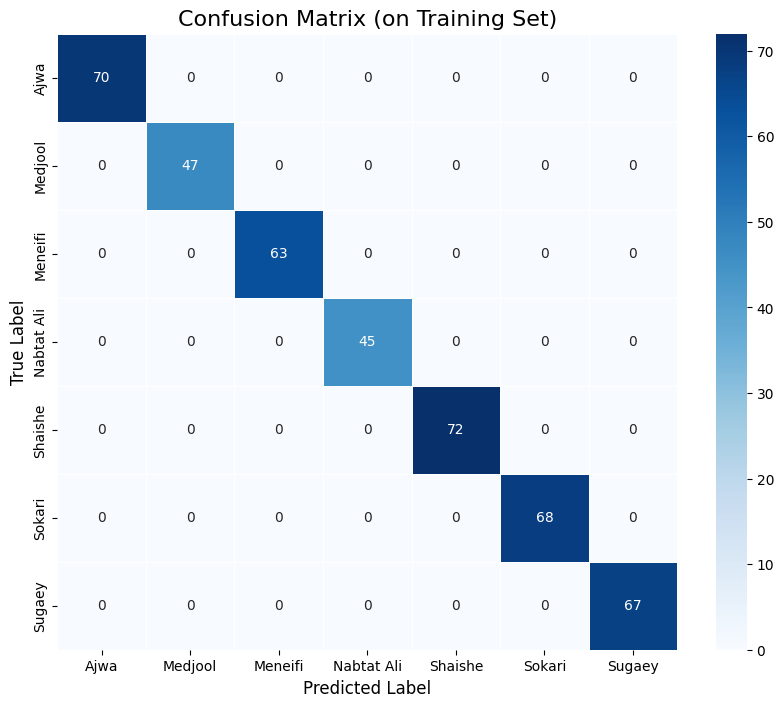

Weighted F1 Score (on Training Set): 1.0000
              precision    recall  f1-score   support

        Ajwa       1.00      1.00      1.00        70
     Medjool       1.00      1.00      1.00        47
     Meneifi       1.00      1.00      1.00        63
  Nabtat Ali       1.00      1.00      1.00        45
     Shaishe       1.00      1.00      1.00        72
      Sokari       1.00      1.00      1.00        68
      Sugaey       1.00      1.00      1.00        67

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions on training data
true_labels = []
train_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:  # Use train loader
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())  # Ground truth labels
        train_predictions.extend(predicted.cpu().numpy())  # Model predictions

# ====================================================
# 13. Plot Confusion Matrix
# ====================================================
# Compute Confusion Matrix
cm = confusion_matrix(true_labels, train_predictions)
cm_df = pd.DataFrame(cm, index=label_mapping.keys(), columns=label_mapping.keys())

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", linewidths=.5)
plt.title("Confusion Matrix (on Training Set)", fontsize=16)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.show()

# ====================================================
# 13. Plot F1-Scores for Each Class
# ====================================================
# Compute & Print F1 Score
f1 = f1_score(true_labels, train_predictions, average="weighted")
print(f"Weighted F1 Score (on Training Set): {f1:.4f}")

# Print Detailed Classification Report
print(classification_report(true_labels, train_predictions, target_names=label_mapping.keys()))


In [ ]:
# ====================================================
# 11. Make Predictions on Test Set
# ====================================================
# Predict on Test Set and Save to CSV
test_predictions = []

model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())

# Convert Predictions to Class Names
label_mapping_inv = {v: k for k, v in label_mapping.items()}
test_predictions_labels = [label_mapping_inv[pred] for pred in test_predictions]

# Save Submission File
submission_df = pd.DataFrame({
    "filename": [os.path.basename(path) for path in test_paths],
    "label": test_predictions_labels
})
submission_df.to_csv("submission.csv", index=False)

print("✅ Submission file saved as submission.csv.")


✅ Submission file saved as submission.csv.


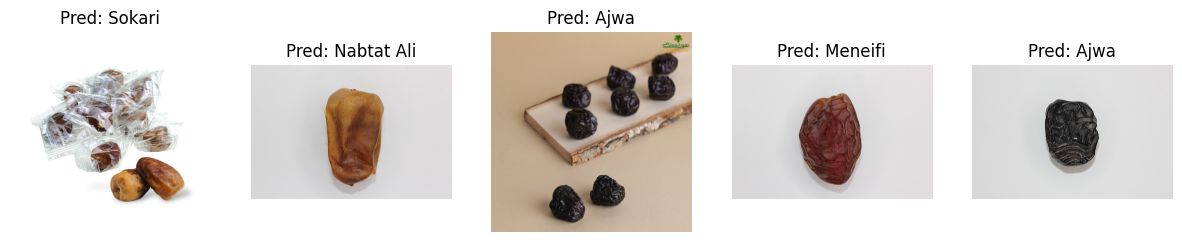

In [ ]:
# ====================================================
# 14. Display Sample Test Predictions
# ====================================================
import random

# Show a few sample predictions
sample_idx = random.sample(range(len(test_df)), 5)
plt.figure(figsize=(15, 10))

# Ensure predictions list is populated before accessing it
# Move this block of code inside the loop:

for idx, i in enumerate(sample_idx):
    img_path = test_df.iloc[i]['path']
    img = Image.open(img_path)

    # Perform prediction for the current image:
    image_tensor = test_transforms(img).unsqueeze(0).to(DEVICE)  # Transform and add batch dimension
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_label = label_mapping_inv[predicted_idx.item()]

    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(f"Pred: {predicted_label}")  # Only display the predicted label
    plt.axis('off')

plt.show()

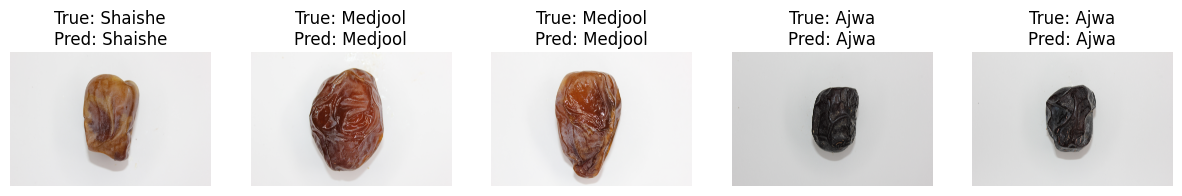

In [ ]:
# ====================================================
# 14. Display Sample Test Predictions with True Labels (from Training Set)
# ====================================================
import random

# Show a few sample predictions from the training set
sample_idx = random.sample(range(len(train_df)), 5) # Sample from train_df
plt.figure(figsize=(15, 10))

for idx, i in enumerate(sample_idx):
    img_path = train_df.iloc[i]['path']
    img = Image.open(img_path)

    # Get the true label for this image
    true_label = train_df.iloc[i]['label']

    # Perform prediction for the current image
    image_tensor = test_transforms(img).unsqueeze(0).to(DEVICE)  # Transform and add batch dimension
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_label = label_mapping_inv[predicted_idx.item()]

    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.show()

In [ ]:
# Function to load and predict on an external image
def predict_image(model, image_path, label_mapping):
    model.eval()  # Set model to evaluation mode
    label_mapping_inv = {v: k for k, v in label_mapping.items()}  # Reverse label mapping

    image = Image.open(image_path).convert('RGB')  # Load image
    image = test_transforms(image).unsqueeze(0).to(DEVICE)  # Apply transforms and add batch dimension

    with torch.no_grad():
        output = model(image)  # Forward pass
        _, predicted_idx = torch.max(output, 1)  # Get predicted class index

    predicted_label = label_mapping_inv[predicted_idx.item()]  # Convert index to label
    print(f"Predicted label: {predicted_label}")

# Example usage (replace 'your_image.jpg' with the actual image path)
image_path = "/content/photo_2025-03-07_06-26-20.jpg"  # Update with your image path
predict_image(model, image_path, label_mapping)

Predicted label: Sokari


In [ ]:
# Function to load and predict on an external image
def predict_image(model, image_path, label_mapping):
    model.eval()  # Set model to evaluation mode
    label_mapping_inv = {v: k for k, v in label_mapping.items()}  # Reverse label mapping

    image = Image.open(image_path).convert('RGB')  # Load image
    image = test_transforms(image).unsqueeze(0).to(DEVICE)  # Apply transforms and add batch dimension

    with torch.no_grad():
        output = model(image)  # Forward pass
        _, predicted_idx = torch.max(output, 1)  # Get predicted class index

    predicted_label = label_mapping_inv[predicted_idx.item()]  # Convert index to label
    print(f"Predicted label: {predicted_label}")

# Example usage (replace 'your_image.jpg' with the actual image path)
image_path = "/content/photo_2025-03-07_06-29-28.jpg"  # Update with your image path
predict_image(model, image_path, label_mapping)

Predicted label: Medjool


# **Prevent Overfitting:**










































.

In [1]:
# ====================================================
# 1. Import Necessary Libraries
# ====================================================
import os
import random
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from glob import glob
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from PIL import Image

In [2]:
# ====================================================
# Configurations
# ====================================================
BATCH_SIZE = 16
IMG_SIZE = 224
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4  # L2 Regularization
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MIXUP_PROB = 0.5

def mixup_data(x, y, alpha=1.0):
    """Applies MixUp augmentation"""
    if alpha > 0 and np.random.rand() < MIXUP_PROB:
        lam = np.random.beta(alpha, alpha)
        index = torch.randperm(x.size(0)).to(DEVICE)
        x = lam * x + (1 - lam) * x[index, :]
        y = lam * y + (1 - lam) * y[index]
    return x, y

In [3]:
# ====================================================
# 3. تحميل البيانات من Kaggle واستخراجها
# ====================================================
from google.colab import files
import zipfile

# رفع ملف kaggle.json يدويًا
files.upload()  # تأكد من رفع kaggle.json

# نقل ملف Kaggle API إلى المكان الصحيح
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# تحميل البيانات
!kaggle competitions download -c open-data-day-2025-dates-types-classification

# استخراج البيانات
with zipfile.ZipFile("open-data-day-2025-dates-types-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

print("✅ Files extracted successfully!")

Saving kaggle.json to kaggle.json
100% 929M/932M [00:50<00:00, 21.4MB/s]
100% 932M/932M [00:50<00:00, 19.2MB/s]
✅ Files extracted successfully!


In [4]:
from pathlib import Path

data_path = Path("/content/data")  # المسار الرئيسي للبيانات
train_path = data_path / "/content/data/train"
test_path = data_path / "/content/data/test"

# قراءة ملف التصنيفات
csv_path = data_path / "/content/data/train_labels.csv"
train_df = pd.read_csv(csv_path)
train_df["path"] = train_path / train_df["filename"]
train_df.drop("filename", axis=1, inplace=True)

test_paths = glob("/content/data/test/*")
test_df = pd.DataFrame({"path": test_paths})

# التحقق من البيانات
print("Train Shape:", train_df.shape)
print("Test  Shape:", test_df.shape)
print(train_df.head())

Train Shape: (432, 2)
Test  Shape: (126, 1)
  label                              path
0  Ajwa  /content/data/train/feda0fb2.jpg
1  Ajwa  /content/data/train/f10703e9.png
2  Ajwa  /content/data/train/04cdb8ab.jpg
3  Ajwa  /content/data/train/56fa4cc4.jpg
4  Ajwa  /content/data/train/e17feef7.jpg


In [5]:
label_mapping = {
    "Ajwa": 0,
    "Medjool": 1,
    "Meneifi": 2,
    "Nabtat Ali": 3,
    "Shaishe": 4,
    "Sokari": 5,
    "Sugaey": 6
}

# Add label indices to DataFrame
train_df["label_idx"] = train_df["label"].map(label_mapping)

In [6]:

# ====================================================
# Data Preprocessing & Augmentation
# ====================================================
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# ====================================================
# Dataset Class
# ====================================================
class DatesDataset(Dataset):
    def __init__(self, dataframe, transform=None, train=True):
        self.dataframe = dataframe
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.train:
            label = self.dataframe.iloc[idx]['label_idx']
            return image, label
        else:
            return image

In [8]:


# ====================================================
# Handle Class Imbalance
# ====================================================
labels = train_df['label'].values
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
sample_weights = train_df['label'].map(lambda x: class_weights[label_to_index[x]].item()).values
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [9]:
# ====================================================
# DataLoaders
# ====================================================
train_dataset = DatesDataset(train_df, transform=train_transforms, train=True)
test_dataset = DatesDataset(test_df, transform=test_transforms, train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# ====================================================
# ✅ Model Definition with Dropout (Fixed)
# ====================================================
model = models.convnext_tiny(pretrained=True)

num_ftrs = model.classifier[2].in_features  # Get original input size (768)

# Define new classifier, ensuring Flatten is included
model.classifier = nn.Sequential(
    nn.Flatten(),              # ✅ Ensure correct input shape (batch_size, 768)
    nn.Linear(num_ftrs, 512),  # Reduce to 512 features
    nn.ReLU(),
    nn.Dropout(0.3),           # Dropout added to reduce overfitting
    nn.Linear(512, len(label_mapping))  # Final output layer
)

model = model.to(DEVICE)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 182MB/s]


In [11]:

# ====================================================
# Loss Function & Optimizer with Weight Decay
# ====================================================
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [12]:

# ====================================================
# Training Loop with MixUp & Learning Rate Scheduler
# ====================================================
def train_model(model, train_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):
    model.train()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    best_loss = float('inf')
    patience, trigger = 5, 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            images, labels = mixup_data(images, labels)  # Apply MixUp
            # Convert labels to long before calculating loss if using MixUp
            labels = labels.type(torch.long)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        scheduler.step(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                print("Early stopping triggered!")
                break

train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.8679
Epoch [2/20], Loss: 1.3899
Epoch [3/20], Loss: 1.3190
Epoch [4/20], Loss: 1.1598
Epoch [5/20], Loss: 0.9282
Epoch [6/20], Loss: 0.7024
Epoch [7/20], Loss: 0.8945
Epoch [8/20], Loss: 0.9141
Epoch [9/20], Loss: 1.0178
Epoch [10/20], Loss: 0.8891
Epoch [11/20], Loss: 0.7237
Early stopping triggered!


In [13]:
# ====================================================
# 12. Make Predictions on Test Set and Save to CSV
# ====================================================
test_predictions = []

model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())

# Convert Predictions to Class Names
label_mapping_inv = {v: k for k, v in label_mapping.items()}
test_predictions_labels = [label_mapping_inv[pred] for pred in test_predictions]

# Save Submission File
submission_df = pd.DataFrame({
    "filename": [os.path.basename(path) for path in test_paths],
    "label": test_predictions_labels
})
submission_df.to_csv("submission.csv", index=False)

print("✅ Submission file saved as submission.csv.")

✅ Submission file saved as submission.csv.


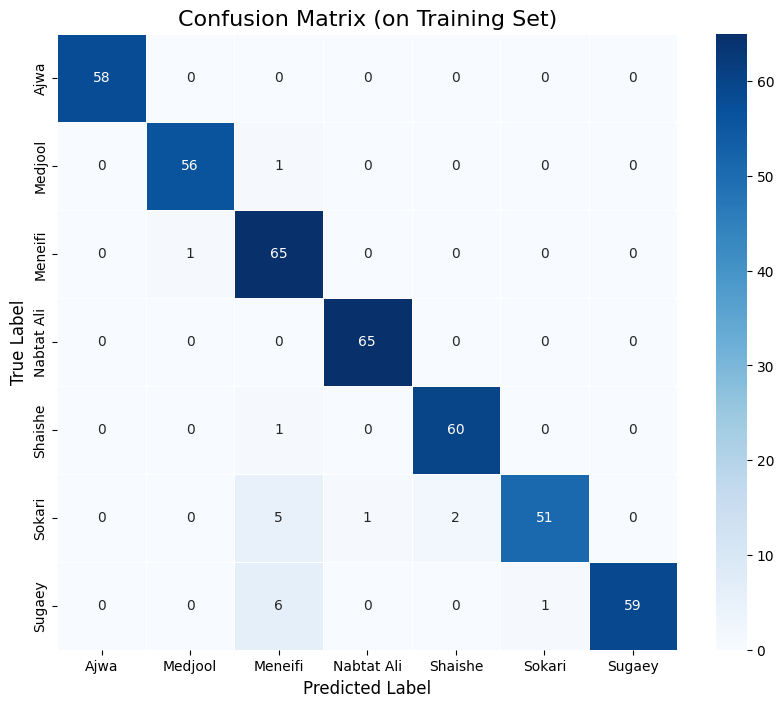

Weighted F1 Score (on Training Set): 0.9586
              precision    recall  f1-score   support

        Ajwa       1.00      1.00      1.00        58
     Medjool       0.98      0.98      0.98        57
     Meneifi       0.83      0.98      0.90        66
  Nabtat Ali       0.98      1.00      0.99        65
     Shaishe       0.97      0.98      0.98        61
      Sokari       0.98      0.86      0.92        59
      Sugaey       1.00      0.89      0.94        66

    accuracy                           0.96       432
   macro avg       0.96      0.96      0.96       432
weighted avg       0.96      0.96      0.96       432



In [14]:


# ====================================================
# 13. Plot Confusion Matrix
# ====================================================
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions on training data
true_labels = []
train_predictions = []  # Initialize train_predictions

model.eval()
with torch.no_grad():
    for images, labels in train_loader:  # Use train loader
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())  # Ground truth labels
        train_predictions.extend(predicted.cpu().numpy())  # Model predictions

# Compute Confusion Matrix
cm = confusion_matrix(true_labels, train_predictions)  # Use true_labels and train_predictions
cm_df = pd.DataFrame(cm, index=label_mapping.keys(), columns=label_mapping.keys())

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", linewidths=.5)
plt.title("Confusion Matrix (on Training Set)", fontsize=16)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.show()

# ====================================================
# 13. Plot F1-Scores for Each Class
# ====================================================
# Compute & Print F1 Score
f1 = f1_score(true_labels, train_predictions, average="weighted")
print(f"Weighted F1 Score (on Training Set): {f1:.4f}")

# Print Detailed Classification Report
print(classification_report(true_labels, train_predictions, target_names=label_mapping.keys()))

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Function to load and predict on an external image
def predict_image(model, image_path, label_mapping):
    model.eval()  # Set model to evaluation mode
    label_mapping_inv = {v: k for k, v in label_mapping.items()}  # Reverse label mapping

    image = Image.open(image_path).convert('RGB')  # Load image
    image = test_transforms(image).unsqueeze(0).to(DEVICE)  # Apply transforms and add batch dimension

    with torch.no_grad():
        output = model(image)  # Forward pass
        _, predicted_idx = torch.max(output, 1)  # Get predicted class index

    predicted_label = label_mapping_inv[predicted_idx.item()]  # Convert index to label
    print(f"Predicted label: {predicted_label}")

# Example usage (replace 'your_image.jpg' with the actual image path)
image_path = "/content/drive/MyDrive/photo_2025-03-07_06-26-20.jpg"  # Update with your image path
predict_image(model, image_path, label_mapping)

Predicted label: Sokari


In [18]:
# Function to load and predict on an external image
def predict_image(model, image_path, label_mapping):
    model.eval()  # Set model to evaluation mode
    label_mapping_inv = {v: k for k, v in label_mapping.items()}  # Reverse label mapping

    image = Image.open(image_path).convert('RGB')  # Load image
    image = test_transforms(image).unsqueeze(0).to(DEVICE)  # Apply transforms and add batch dimension

    with torch.no_grad():
        output = model(image)  # Forward pass
        _, predicted_idx = torch.max(output, 1)  # Get predicted class index

    predicted_label = label_mapping_inv[predicted_idx.item()]  # Convert index to label
    print(f"Predicted label: {predicted_label}")

# Example usage (replace 'your_image.jpg' with the actual image path)
image_path = "/content/drive/MyDrive/photo_2025-03-07_06-29-28.jpg"  # Update with your image path
predict_image(model, image_path, label_mapping)

Predicted label: Medjool


Accuracy on external data: 89.94%

Classification Report:
              precision    recall  f1-score   support

        Ajwa       1.00      1.00      1.00       175
     Medjool       0.96      0.99      0.97       135
     Meneifi       0.67      0.99      0.80       232
  Nabtat Ali       0.98      0.99      0.98       177
     Shaishe       0.96      0.91      0.93       171
      Sokari       0.99      0.80      0.88       264
      Sugaey       1.00      0.65      0.79       168

    accuracy                           0.90      1322
   macro avg       0.94      0.90      0.91      1322
weighted avg       0.93      0.90      0.90      1322



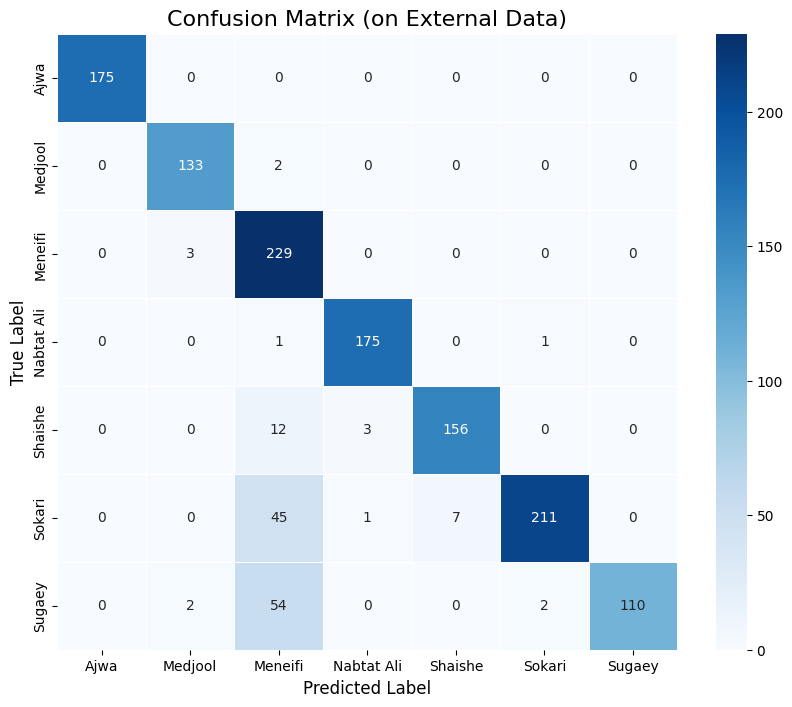

In [19]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ====================================================
# Load External Data (Filter Unmatched Labels)
# ====================================================
external_data_path = "/content/drive/MyDrive/archive-2"  # Replace with the path to your external data
valid_labels = {"Ajwa", "Medjool", "Meneifi", "Nabtat Ali", "Shaishe", "Sokari", "Sugaey"}  # Your dataset's labels

external_data = []
for label in os.listdir(external_data_path):
    if label not in valid_labels:
        continue  # Skip unmatched labels (Galaxy, Rutab)
    label_path = os.path.join(external_data_path, label)
    if os.path.isdir(label_path):  # Ensure it's a directory
        for file in os.listdir(label_path):
            file_path = os.path.join(label_path, file)
            external_data.append({"path": file_path, "label": label})

external_df = pd.DataFrame(external_data)

# Map labels to indices
label_mapping = {
    "Ajwa": 0,
    "Medjool": 1,
    "Meneifi": 2,
    "Nabtat Ali": 3,
    "Shaishe": 4,
    "Sokari": 5,
    "Sugaey": 6
}
external_df["label_idx"] = external_df["label"].map(label_mapping)

# ====================================================
# Create Dataset and DataLoader for External Data
# ====================================================
external_dataset = DatesDataset(external_df, transform=test_transforms, train=True)
external_loader = DataLoader(external_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ====================================================
# Generate Predictions on External Data
# ====================================================
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in external_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# ====================================================
# Calculate Accuracy
# ====================================================
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy on external data: {accuracy * 100:.2f}%")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=label_mapping.keys()))

# Plot Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm, index=label_mapping.keys(), columns=label_mapping.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", linewidths=.5)
plt.title("Confusion Matrix (on External Data)", fontsize=16)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.show()
